# Lab 2: Cats vs Dogs

**Deadline**: Feb 07, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Saba Ale Ebrahim -- saba.aleebrahim@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1yshV44f32QBo-LYVQAOlv5jmkf5BedCR#scrollTo=SwyDuiuUqIDv&uniqifier=4

In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [2]:

## Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.
    """

    # Param1 {dataset} : Dataset object
    # Param2 {classes} : A list of strings denoting the name of each class
    # Param3 {target_classes} : A list of strings denoting the name of desired classes. Should be a subset of the 'classes'

    # Returns: indices list of indices that have labels corresponding to one of the target classes

    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices


def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.
    """

    # Param1 {target_classes} : A list of strings denoting the name of the desired classes. Should be a subset of the argument 'classes' classes. Should be a subset of the argument 'classes'
    # Param2 {batch_size} : A int representing the number of samples per batch

    # Returns: {train_loader}: iterable training dataset organized according to batch size
    # Returns: {val_loader}: iterable validation dataset organized according to batch size
    # Returns: {test_loader}: iterable testing dataset organized according to batch size
    # Returns: {classes}: A list of strings denoting the name of each class

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    #$ Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    #$ split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]

    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=train_sampler)

    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, num_workers=1, sampler=val_sampler)

    #$ Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=1, sampler=test_sampler)

    return train_loader, val_loader, test_loader, classes


## Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values """

    # Param1 {config} : Configuration object containing the hyperparameters
    # Return: A string with the hyperparameter name and value concatenated

    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path


def normalize_label(labels):
    """ Given a tensor containing 2 possible values, normalize this to 0/1 """

    # Param1 {labels} : a 1D tensor containing two possible scalar values
    # Return: A tensor normalize to 0 / 1 value

    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val) / (max_val - min_val)
    return norm_labels


def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

## Training Curve


def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1, n + 1), train_err, label="Train")
    plt.plot(range(1, n + 1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1, n + 1), train_loss, label="Train")
    plt.plot(range(1, n + 1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

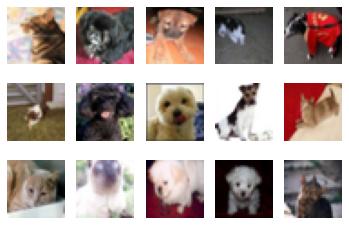

In [5]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1, 2, 0]) #/ convert from [3, 32, 32] to [32, 32, 3]
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k + 1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [6]:
train_num = len(train_loader) 
test_num = len(test_loader) 
val_num = len(val_loader)

print(f'Number of training images: {train_num}')
print(f'Number of testing images: {test_num}')
print(f'Number of validation images: {val_num}')

Number of training images: 8000
Number of testing images: 2000
Number of validation images: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [7]:
# We need a validation set in order to perform a sanity check that our training model isn't overfiting. As we increase the number of looping iterations, the validation error generally decrease then increase. When the validation error start to increase, we usually stop the optimization to avoid overfitting.
# If we do not use a validation set loss/error and solely rely on the training loss/error, we may have biased hyperparameters that are not representative of the data population (which includes validation and test data)

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [8]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x


In [9]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7) # convert to the size of linear layer input
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [10]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [11]:
'''--------- Answer ---------'''
small_param_num = 0
large_param_num = 0

for param in small_net.parameters():
    print(param.shape)
    small_param_num = small_param_num + param.numel()

print('------------divider-------------')
print('large_net')
for param in large_net.parameters():
    print(param.shape)
    large_param_num = large_param_num + param.numel()

print('------------divider-------------')
print('small_param_num: ', small_param_num)
print('large_param_num: ', large_param_num)


torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
------------divider-------------
large_net
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
------------divider-------------
small_param_num:  386
large_param_num:  9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [12]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ## Trainng setup
    #$ Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]

    #$ Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    #$ Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
        target_classes, batch_size)

    #$ Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    #$ Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    ## Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    
    total_train_loss = 0.0
    total_train_err = 0.0
    total_epoch = 0
        
        
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
            
        #$ For each epoch
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |" +
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')


    ## Calculate elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    ## Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [13]:
# As indicated by the function prototype, 
# def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30)
# Default parameters of batch size, learning rate and number of epochs are 64, 0.01 and 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [14]:
train_net(small_net,num_epochs=5)
'''--------- Answer ---------'''
# When train_net are trained for 5 epochs, 4 csv files are generated. Each contains validation error/loss values and the train error/values) 
# After the final epoch complete, a disk file that saves the current version of the neural network that was developed per epoch (i.e. 5 disk output files).

# List of all the files written to disk, and what information the files contain

# the current model with 4 checkpoints:
# model_small_bs64_lr0.01_epoch0: checkpoint at epoch 0
# model_small_bs64_lr0.01_epoch1: checkpoint at epoch 1
# model_small_bs64_lr0.01_epoch2: checkpoint at epoch 2
# model_small_bs64_lr0.01_epoch3: checkpoint at epoch 3
# model_small_bs64_lr0.01_epoch4: checkpoint at epoch 4

# files with error and loss:
# model_small_bs64_lr0.01_epoch4_train_err.csv: training error
# model_small_bs64_lr0.01_epoch4_train_loss.csv: training loss
# model_small_bs64_lr0.01_epoch4_val_err.csv: validation error
# model_small_bs64_lr0.01_epoch4_val_loss.csv: validation loss

Files already downloaded and verified
Files already downloaded and verified


KeyboardInterrupt: 

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet()
large_net = LargeNet()
train_net(small_net)
train_net(large_net)
# Time for training small and large network are 96.14 seconds and 105.05 seconds.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43925, Train loss: 0.6837761998176575 |Validation err: 0.3915, Validation loss: 0.6662304494529963
Epoch 2: Train err: 0.381, Train loss: 0.6527652173042298 |Validation err: 0.3935, Validation loss: 0.6627088207751513
Epoch 3: Train err: 0.342125, Train loss: 0.6253658514022827 |Validation err: 0.335, Validation loss: 0.618512349203229
Epoch 4: Train err: 0.324, Train loss: 0.6055522425174713 |Validation err: 0.3375, Validation loss: 0.6168343275785446
Epoch 5: Train err: 0.314, Train loss: 0.5930070235729218 |Validation err: 0.32, Validation loss: 0.6096986010670662
Epoch 6: Train err: 0.299875, Train loss: 0.5810152497291565 |Validation err: 0.326, Validation loss: 0.605014132335782
Epoch 7: Train err: 0.297125, Train loss: 0.5772572119235992 |Validation err: 0.332, Validation loss: 0.6006468189880252
Epoch 8: Train err: 0.293625, Train loss: 0.5692502632141113 |Validation err: 0.3085, V

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_path = get_model_name("large", batch_size = 64, learning_rate = 0.01, epoch = 29)

Plots for the Small NN: 


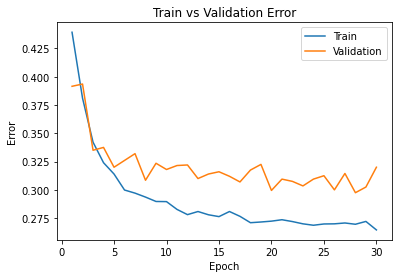

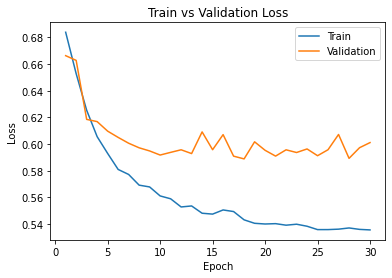

Plots for the Large NN: 


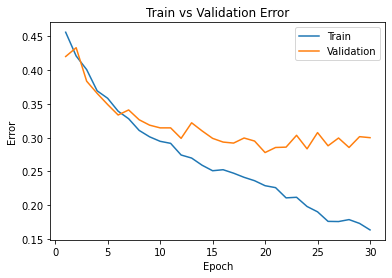

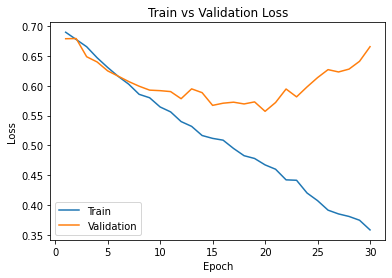

In [ ]:
print("Plots for the Small NN: ")
plot_training_curve(small_path)
print("Plots for the Large NN: ")
plot_training_curve(large_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# At the beginning, the curve for decreases both the loss and error of both large and small network decrease with increasing epochs. The optimizer continuously improve the parameters. 
#
# However, after 5 epochs on large network and 10 epochs on small network, the validation curves stop decreasing. 
#
# To be specific, for the small network, the validation eror and loss almost stay at the ssme level after epoch 10. And for the large network validation loss even increases. This is obviously a signal of overfitting. The model memorize the training set, and fails to generalize to other images.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.

large_net = LargeNet()
train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.6930043635368347 |Validation err: 0.509, Validation loss: 0.6931596361100674
Epoch 2: Train err: 0.4915, Train loss: 0.6926670327186585 |Validation err: 0.5005, Validation loss: 0.6926120761781931
Epoch 3: Train err: 0.482125, Train loss: 0.6923308362960815 |Validation err: 0.469, Validation loss: 0.6922504659742117
Epoch 4: Train err: 0.464375, Train loss: 0.6919894490242005 |Validation err: 0.437, Validation loss: 0.6916331630200148
Epoch 5: Train err: 0.44525, Train loss: 0.6915650143623352 |Validation err: 0.412, Validation loss: 0.6911924947053194
Epoch 6: Train err: 0.440375, Train loss: 0.6910408339500427 |Validation err: 0.414, Validation loss: 0.6902638506144285
Epoch 7: Train err: 0.438625, Train loss: 0.6903441557884217 |Validation err: 0.411, Validation loss: 0.6893651075661182
Epoch 8: Train err: 0.439625, Train loss: 0.6893503012657165 |Validation err: 0.

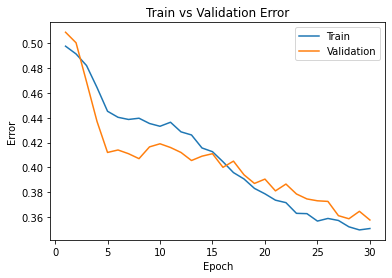

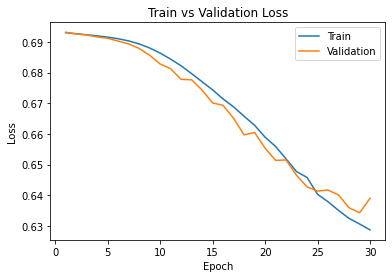

In [ ]:
'''--------- Answer ---------'''
# plot
large_path = get_model_name("large", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(large_path)

# The model takes almost the same time as the previous one with learning_rate = 0.01
# For training, lower the learning rate gets higher error and higher loss. 
# For validation, the error and loss is also higher. However, the training and validation curve are closer to each other, and overfitting, as we see in the case of learning_rate = 0.01 is avoided

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44175, Train loss: 0.6831841006278991 |Validation err: 0.434, Validation loss: 0.6745143346488476
Epoch 2: Train err: 0.382625, Train loss: 0.6530101780891419 |Validation err: 0.3865, Validation loss: 0.6536255516111851
Epoch 3: Train err: 0.366375, Train loss: 0.637329571723938 |Validation err: 0.3895, Validation loss: 0.639661705121398
Epoch 4: Train err: 0.34975, Train loss: 0.6220996608734131 |Validation err: 0.3645, Validation loss: 0.6587472148239613
Epoch 5: Train err: 0.32875, Train loss: 0.6066574172973633 |Validation err: 0.314, Validation loss: 0.6086326455697417
Epoch 6: Train err: 0.3215, Train loss: 0.5905110754966736 |Validation err: 0.338, Validation loss: 0.6043118145316839
Epoch 7: Train err: 0.301125, Train loss: 0.5761607422828674 |Validation err: 0.3265, Validation loss: 0.6079260557889938
Epoch 8: Train err: 0.301625, Train loss: 0.5674372136592865 |Validation err: 0.

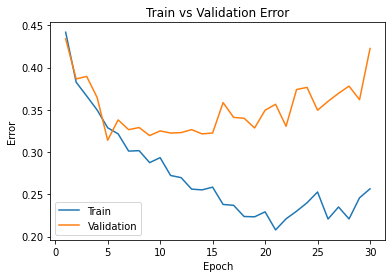

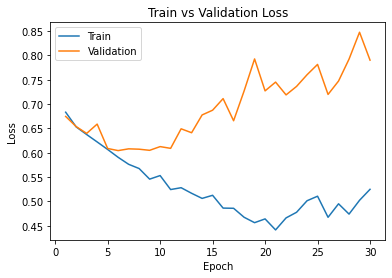

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate=0.1)

large_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_path)

# The model takes almost the same time as before
# Increasing the learning rate causes the overfitting to happen earlier than in learning_rate=0.01. Also, the error and loss are higher in this case.
# The plot indicates that the learning_rate=0.1 is too fast for this model.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

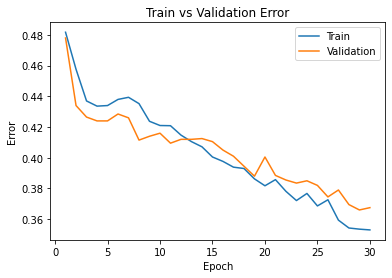

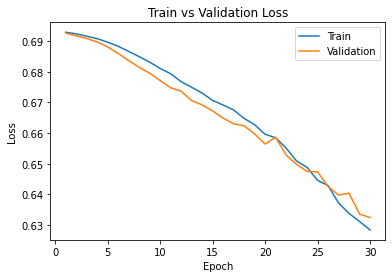

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
large_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

# The model takes less time to train. Because when batch_size increases, the numnber of iteration in 1 epoch is smaller.

# Increasing the batch size gets higher error and higher loss in the training data. 
# However, increasing the batch size avoids overfitting of the model.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

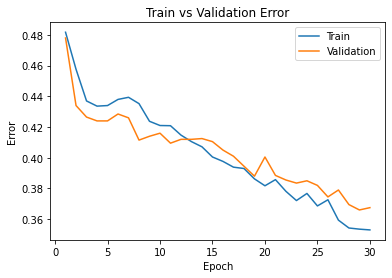

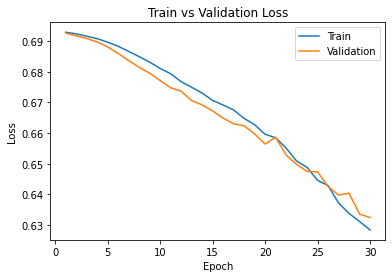

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

large_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_path)

# Decreasing the batch size increase the time to train because, the number of iteration increases.

# For training, decreasing the batch size gets lower error and lower loss.
# For validation, the loss and error are very large, still above 60% when epoch = 30

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# I choose network = large_net; batch_size = 128, learning_rate = 0.01, and epoch = 30
# Large net works better than small net because they have more parameters
# From part 3, we see that 0.01 is moderate learning rate
# The model would get overfitting When batch_size is small, from last part 128 is a good choice. Peformance is better and shows no sign of overfitting.
# 30 is a good number of epoch to avoid overfitting and underfitting

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.495875, Train loss: 0.6931184946544586 |Validation err: 0.4805, Validation loss: 0.6916408091783524
Epoch 2: Train err: 0.451, Train loss: 0.6894772081148057 |Validation err: 0.4295, Validation loss: 0.6861000396311283
Epoch 3: Train err: 0.437, Train loss: 0.6839284404875741 |Validation err: 0.4285, Validation loss: 0.6790804788470268
Epoch 4: Train err: 0.426875, Train loss: 0.6780795492823162 |Validation err: 0.4165, Validation loss: 0.6707140244543552
Epoch 5: Train err: 0.405, Train loss: 0.670255338388776 |Validation err: 0.3955, Validation loss: 0.6617481596767902
Epoch 6: Train err: 0.375375, Train loss: 0.655164292880467 |Validation err: 0.371, Validation loss: 0.6447778306901455
Epoch 7: Train err: 0.371625, Train loss: 0.6452617872328985 |Validation err: 0.362, Validation loss: 0.6367651708424091
Epoch 8: Train err: 0.352375, Train loss: 0.630987182496086 |Validation err: 0.344,

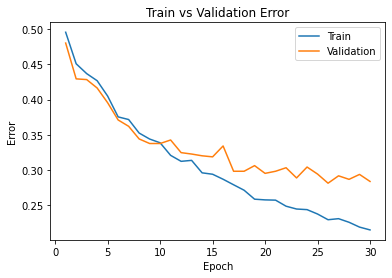

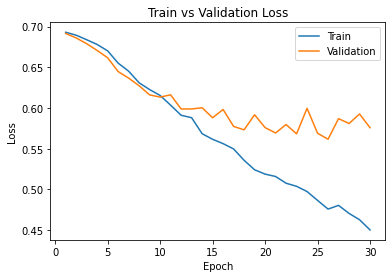

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.01, 30)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# I choose the set of parameter as: (network = large_net, batch_size = 128, learning_rate = 0.008, epoch = 22)
# I choose to decrease the epoch because in part(b)'s training, in epoch after 22, the loss are actually rising again.
# I choose to decrease the learning rate such that the training model can make more delicate decision.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.45575, Train loss: 0.6922450169684395 |Validation err: 0.426, Validation loss: 0.6905863583087921
Epoch 2: Train err: 0.4465, Train loss: 0.6892826831530011 |Validation err: 0.4125, Validation loss: 0.6848023012280464
Epoch 3: Train err: 0.429125, Train loss: 0.6841231499399457 |Validation err: 0.415, Validation loss: 0.6779178753495216
Epoch 4: Train err: 0.417875, Train loss: 0.6779375975094144 |Validation err: 0.409, Validation loss: 0.6702326275408268
Epoch 5: Train err: 0.407375, Train loss: 0.6721536148162115 |Validation err: 0.402, Validation loss: 0.6651363223791122
Epoch 6: Train err: 0.39275, Train loss: 0.6656142605675591 |Validation err: 0.3915, Validation loss: 0.6601980663836002
Epoch 7: Train err: 0.38225, Train loss: 0.658364697108193 |Validation err: 0.3855, Validation loss: 0.651749849319458
Epoch 8: Train err: 0.374375, Train loss: 0.6494464685046484 |Validation err: 0.3

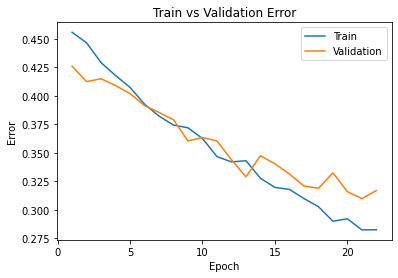

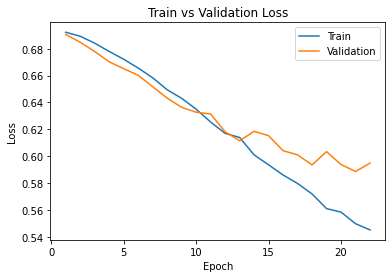

In [ ]:
large_net = LargeNet()
train_net(large_net, 128, 0.008, 22)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.008, epoch=21)
plot_training_curve(model_path_large)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet() #/ modified to large net
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.008, epoch=21)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# Validation error from the training from part(a) is: 0.299
# Validation loss from the training from part(a): 0.580
# Both are better than previous result.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

criterion = nn.BCEWithLogitsLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print("test classification error and loss:", test_err, test_loss) 

Files already downloaded and verified
Files already downloaded and verified
test classification error and loss: 0.312 0.5801096949726343


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
# The test classification error is lower than the validation error.
# Because we train the data in training set and do validation on validation set,
# the model is gradually becoming a good fit for the training dataset and validation set.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [ ]:
# Test data are separated from the training and validation data and not tested till we finished training. Our model never learn the test data so they are unbiased and can evaluate how the model actually fit. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48725, Train loss: 0.6919894767185998 |Validation err: 0.4695, Validation loss: 0.6913558579981327
Epoch 2: Train err: 0.46475, Train loss: 0.6892073116605244 |Validation err: 0.4545, Validation loss: 0.6889092139899731
Epoch 3: Train err: 0.445375, Train loss: 0.6868697121029809 |Validation err: 0.445, Validation loss: 0.6871356442570686
Epoch 4: Train err: 0.43675, Train loss: 0.6846547779582796 |Validation err: 0.4435, Validation loss: 0.6850060001015663
Epoch 5: Train err: 0.428625, Train loss: 0.6826562503027538 |Validation err: 0.437, Validation loss: 0.6833676807582378
Epoch 6: Train err: 0.42375, Train loss: 0.6810154205276853 |Validation err: 0.4325, Validation loss: 0.6821119450032711
Epoch 7: Train err: 0.4205, Train loss: 0.6793432595237853 |Validation err: 0.433, Validation loss: 0.6804986447095871
Epoch 8: Train err: 0.4125, Train loss: 0.6779036029936776 |Validation err: 0.4

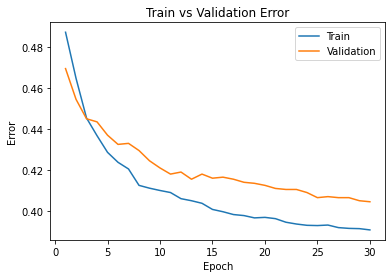

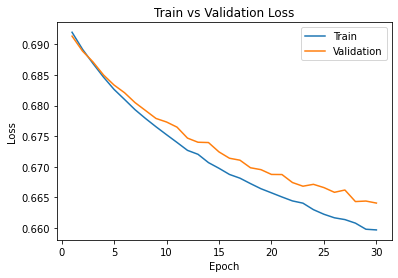

In [ ]:
torch.manual_seed(1) #/ random seed


class CatAndDog(nn.Module): # 2-layer artificial neural network
    def __init__(self):
        self.name = "CatAndDog"
        super(CatAndDog, self).__init__()
        self.layer1 = nn.Linear(3 * 32 * 32, 60)
        self.layer2 = nn.Linear(60, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

train_ANN = CatAndDog()
train_net(train_ANN, batch_size=128, learning_rate=0.0001, num_epochs=30)

cdpath = get_model_name("CatAndDog", batch_size=128, learning_rate=0.0001, epoch=29) 
plot_training_curve(cdpath)

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

err, loss = evaluate(train_ANN, test_loader, nn.BCEWithLogitsLoss())
print("Test error: ", err)
print("Test loss: ", loss)

Files already downloaded and verified
Files already downloaded and verified
Test error:  0.3835
Test loss:  0.6566048040986061


In [ ]:
err, loss = evaluate(train_ANN, val_loader, nn.BCEWithLogitsLoss())
print("Validation error: ", err)
print("Validation loss: ", loss)

Validation error:  0.4045
Validation loss:  0.6646838076412678
